# Project
## Mengxiang Jiang

The majority of the code and images here comes from the [Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks) by François Chollet, specifically chapter 12.
If the code comes from somewhere else it will have a source linked to the original.\
[Short Video Link](https://youtu.be/-iCtO2NW8zg)\
[Long Video Link](https://youtu.be/-iCtO2NW8zg)

### Implementing a VAE with Keras
**VAE encoder network**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

2023-04-29 21:51:10.090480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 21:51:10.153327: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 32)   4640        ['conv2d_1[0][0]']         

2023-04-29 21:51:10.915637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 21:51:10.918307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 21:51:10.918375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 21:51:10.918554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

**Latent-space-sampling layer**

In [2]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**VAE decoder network, mapping latent space points to images**

In [3]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 16))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 256)               768       
                                                                 
 reshape (Reshape)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         9280      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       9248

**VAE model with custom `train_step()`**

In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Processing Cats and Dogs Audio Files
Using code examples from Audio Data Processing in Python by Rob Mulla [source](https://youtu.be/ZqpSb5p1xQo)

**imports for audio**

In [5]:
import os
import numpy as np
import librosa
import IPython.display as ipd

**Playing Audio Example**

In [6]:
example = 'cats_dogs/cat_55.wav'

ipd.Audio(example)

**Read Audio Example**

In [7]:
y, sr = librosa.load(example)
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-4.7695365e-13 -2.7231846e-13  6.0946902e-13 -1.0876644e-12
  1.0821471e-13 -7.5358697e-13  1.1852891e-12 -3.9097398e-13
  5.9609826e-13  7.5963156e-13]
shape y: (20360,)
sr: 22050


**Plot of Audio File**

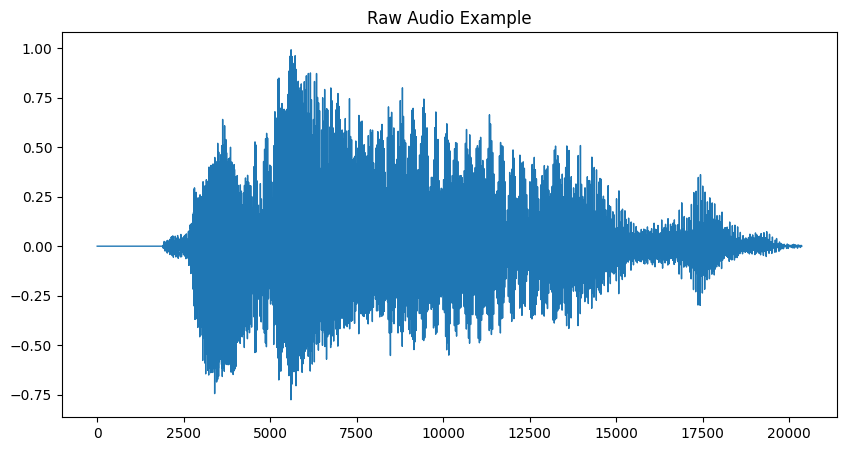

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                  color=color_pal[0])
plt.show()

**Plot of Trimmed Audio File**

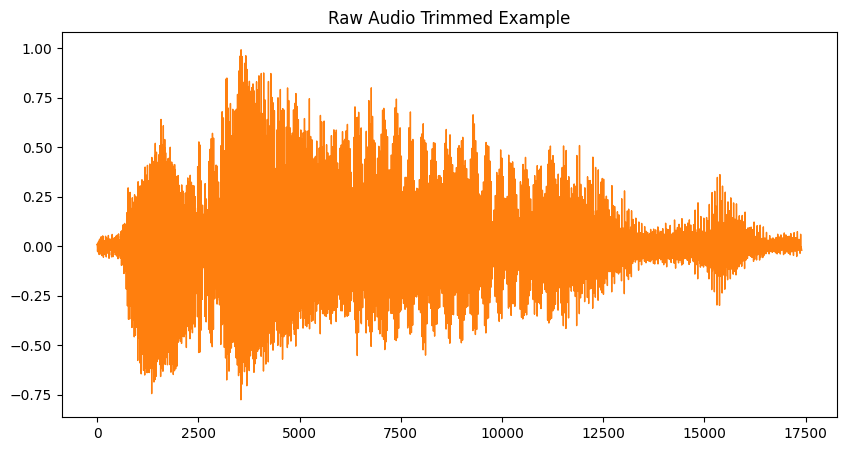

In [9]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                  color=color_pal[1])
plt.show()

In [10]:
y_truncated = y_trimmed[:8157]
D = librosa.stft(y_truncated, n_fft=256)[:128]
y_hat = librosa.istft(np.abs(D))
print(y_hat.shape)
ipd.Audio(y_hat, rate=sr)

(8001,)


**create STFT data**

In [11]:
SOUND_FILES = 'cats_dogs/'
stft_data = []
for sound in os.listdir(SOUND_FILES):
    x, sr = librosa.load(SOUND_FILES + sound)
    x_trimmed, _ = librosa.effects.trim(x, top_db=20)
    # truncate to only 0.37 seconds (8157 samples)
    x_trimmed_truncated1 = x_trimmed[:8157]
    #x_trimmed_truncated2 = x_trimmed[-8157:]
    X1 = librosa.stft(x_trimmed_truncated1, n_fft=256)[:128]
    #X2 = librosa.stft(x_trimmed_truncated2, n_fft=256)[:128]
    stft_data.append(np.abs(X1))
    #stft_data.append(np.abs(X2))



In [12]:
stft_data = np.array(stft_data)
print(stft_data.shape)
stft_max = np.max(np.abs(stft_data))
print(stft_max)
stft_data = np.expand_dims(stft_data, -1).astype("float32") / stft_max
print(stft_data.shape)
np.random.shuffle(stft_data)


(277, 128, 128)
113.416275
(277, 128, 128, 1)


**Training the VAE**

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(stft_data, epochs=1000)

Epoch 1/1000


2023-04-29 21:51:25.608892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-04-29 21:51:26.004380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-29 21:51:26.154651: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c3e9e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-29 21:51:26.154670: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-04-29 21:51:26.157248: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-29 21:51:26.217471: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

9/9 [==============================] - 4s 23ms/step - total_loss: 11160.8555 - reconstruction_loss: 11160.8438 - kl_loss: 0.0110
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 8684.9424 - reconstruction_loss: 8672.5723 - kl_loss: 9.9031
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 1947.8594 - reconstruction_loss: 1191.6913 - kl_loss: 785.5114
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - total_loss: 761.5318 - reconstruction_loss: 754.8977 - kl_loss: 6.7593
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 670.9496 - reconstruction_loss: 668.6189 - kl_loss: 2.3567
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 589.4827 - reconstruction_loss: 588.2106 - kl_loss: 1.2820
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - total_loss: 533.8676 - reconstruction_loss: 533.0129 - kl_loss: 0.8585
Epoch 8/1000
9/9 [=========================

**Sampling a grid of sounds from the 2D latent space**

1/1 [==============================] - 0s 10ms/step


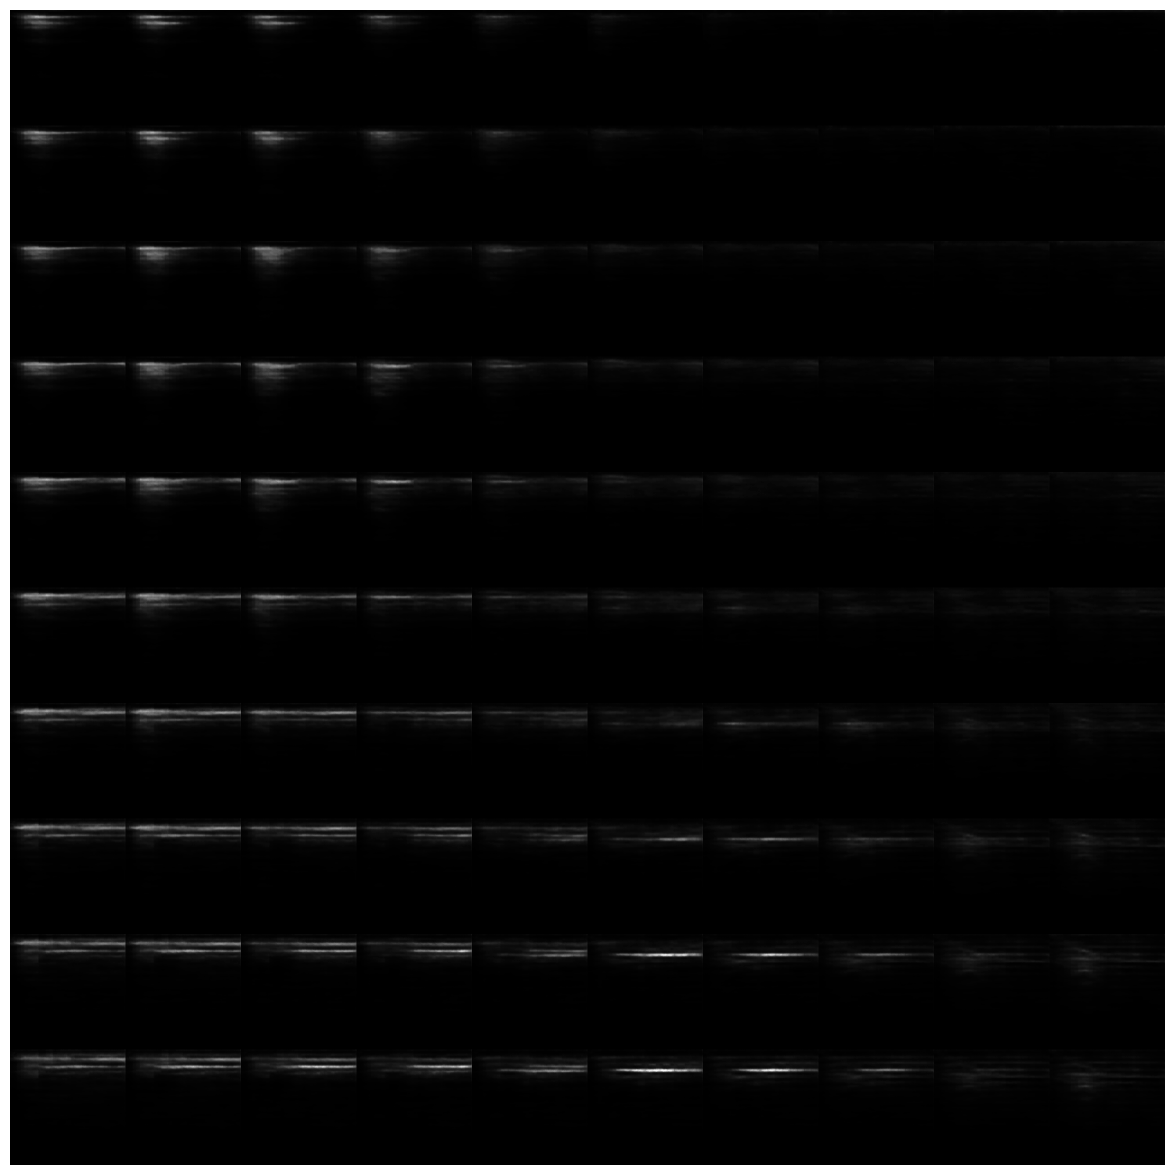

In [14]:
import matplotlib.pyplot as plt

n = 10
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

**Sampling a random sound from the 2D latent space**

In [34]:
import soundfile as sf
import random

z_sample = np.array([[random.uniform(-1, 1), random.uniform(-1, 1)]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*stft_max
X = librosa.istft(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 10ms/step


In [16]:
z_sample = np.array([[-1, -1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*stft_max
X = librosa.istft(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 58ms/step


In [17]:
z_sample = np.array([[-1, 1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*stft_max
X = librosa.istft(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 10ms/step


In [18]:
z_sample = np.array([[1, -1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*stft_max
X = librosa.istft(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 10ms/step


In [19]:
z_sample = np.array([[1, 1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*stft_max
X = librosa.istft(x_decoded)
ipd.Audio(X, rate=sr)

1/1 [==============================] - 0s 11ms/step
